In [ ]:
!pip install jellyfish
!pip install seaborn
!pip install langdetect
!pip install bulwark
!pip install scikit-learn==1.0.2
!pip install teradatasql
!pip install dask
!python -m pip install dask distributed --upgrade

# Detect fraud in swift messages with no previous history to train with

In [ ]:
import pandas as pd
import numpy as np
import teradatasql as tera
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import jellyfish as jello
from typing import Union
import seaborn as sns
from matplotlib import pyplot as plt
from langdetect import detect
import gc
import os
from dask.distributed import Client
import bulwark.decorators as dc
import bulwark.checks as ck
import dask
import dask.dataframe as dd
import joblib
import teradatasql
from tqdm import tqdm

client = Client()

/databricks/python/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33929 instead
 f"Port {expected} is already in use.\n"

### Read historical data

In [ ]:
user_teradata = "USER"
pwd_teradata = "PWD"
HOST = "HOST.HOSTED.CL"
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
SWIFTS = "HISTORY_ALERTS"

with teradatasql.connect(host=HOST,user=user_teradata,password=pwd_teradata) as con:
    """_summary_
    """
    with con.cursor () as cur:
        sTableName = SWIFTS
        try:
            sRequest = "SELECT DISTINCT s_semilla, s_revision FROM " + sTableName
            print (sRequest)
            cur.execute(sRequest)
            data = cur.fetchall()
            headers = [i[0] for i in cur.description] 
        except Exception as ex:
            print ("Ignoring", str (ex).split ("\n") [0])
            
data = list(tuple(d) for d in data)
df_history = pd.DataFrame(data, columns =headers)

SELECT DISTINCT s_semilla, s_revision FROM BCISF.SWIFT_ALERTS_HISTORY

### Read messages of type 1 (mt103)

In [ ]:
SWIFTS = "MESSAGES_1"
mt103 = ""
with teradatasql.connect(host=HOST,user=user_teradata,password=pwd_teradata) as con:
    """ Read messages of type 1 from the past year
    """
    with con.cursor () as cur:
        sTableName = SWIFTS
        try:
            sRequest = "SELECT DISTINCT * FROM " + sTableName + " WHERE CAST(s_fecha_dato AS DATE) >= ADD_MONTHS(CURRENT_DATE, -12)"
            print (sRequest)
            cur.execute(sRequest)
            data = [1]
            headers = ""
            records = 0
            while len(data) != 0:
                data = cur.fetchmany(25000)
                records += len(data)
                print(records, len(data))
                if isinstance(headers, str):
                    headers = [i[0] for i in cur.description] 
                if len(data) != 0:
                    data = list(tuple(d) for d in data)
                    daskdata = dd.from_array(np.array(data), columns =headers)
                    if isinstance(mt103, str):
                        mt103 = daskdata
                    else:
                        mt103 = mt103.append(daskdata)
        except Exception as ex:
            print ("Ignoring", str (ex).split ("\n") [0])

SELECT DISTINCT * FROM BCISF.SWIFT_MT103 WHERE CAST(s_fecha_dato AS DATE) >= ADD_MONTHS(CURRENT_DATE, -12)
25000 25000
50000 25000
75000 25000
100000 25000
125000 25000
150000 25000
175000 25000
190708 15708
190708 0

### Read messages of type 2

In [ ]:
SWIFTS = "MESSAGES_2"
mt202 = ""
with teradatasql.connect(host=HOST,user=user_teradata,password=pwd_teradata) as con:
    """ Read messages of type 2 from the past year
    """
    with con.cursor () as cur:
        sTableName = SWIFTS
        try:
            sRequest = "SELECT DISTINCT * FROM " + sTableName + " WHERE CAST(s_fecha_dato AS DATE) >= ADD_MONTHS(CURRENT_DATE, -12)"
            print (sRequest)
            cur.execute(sRequest)
            data = [1]
            headers = ""
            while len(data) != 0:
                data = cur.fetchmany(25000)
                if isinstance(headers, str):
                    headers = [i[0] for i in cur.description] 
                if len(data) != 0:
                    data = list(tuple(d) for d in data)
                    daskdata = dd.from_array(np.array(data), columns =headers)
                    if isinstance(mt202, str):
                        mt202 = daskdata
                    else:
                        mt202 = mt202.append(daskdata)
        except Exception as ex:
            print ("Ignoring", str (ex).split ("\n") [0])

SELECT DISTINCT * FROM BCISF.SWIFT_MT202 WHERE CAST(s_fecha_dato AS DATE) >= ADD_MONTHS(CURRENT_DATE, -12)

#### Rename variables to a human readable form

In [ ]:
renaming = {}
for col in mt103.columns.values.tolist():
    if col != "s_semilla" and col != 's_iso_week':
        restitute = " ".join(col.split("_")[1:]).capitalize()
        renaming[col] = restitute
    else:
        if col == "s_semilla":
            renaming[col] = "semilla"
        elif col == 's_iso_week':
            renaming[col] = "ISO week"
mt103 = mt103.rename(columns=renaming)

renaming = {}
for col in mt202.columns.values.tolist():
    if col != "s_semilla" and col != 's_iso_week':
        restitute = " ".join(col.split("_")[1:]).capitalize()
        renaming[col] = restitute
    else:
        if col == "s_semilla":
            renaming[col] = "semilla"
        elif col == 's_iso_week':
            renaming[col] = "ISO week"
mt202 = mt202.rename(columns=renaming)
mt103["Amount"] = mt103["Amount"].astype("float")
mt202["Amount"] = mt202["Amount"].astype("float")

### Helper functions

In [ ]:
def sus_bank(row: pd.Series, transaction_map: dict, query_type="Bank") -> int:
    """ Según las probabilidades direccionales de transacción, devuelve 1 si la interacción de dos bancos es poco probable

    Args:
        transaction_map (dict): Mapa de transacciones con probabilidades por banco de envío de transacción
        row (pd.Series): Fila a revisar
        query_type (str): Tipo de mapa de contactos disponible

    Returns:
        int: 1 si transacción es poco probable, 0 en otro caso
    """
    if query_type == "Bank":
        sender = row['Sender']
        receiver = row["Receiver"]
    else:
        sender = row["Ordering customer account"]
        receiver = row["Beneficiary customer account"]
    if sender in transaction_map.keys():
        interacciones = transaction_map[sender]
        if receiver in interacciones.keys():
            if query_type != "Bank":
                cl = row["Contact list"]
                div = 2
            else:
                cl = len(list(interacciones.keys()))
                div = 1
            if interacciones[receiver] < 0.4*(1/max(int(cl/div), 1)):
                return 1
            else:
                return 0
        else:
            return 1
    else:
        return 1

In [ ]:
def contact_book(row: pd.Series, transaction_map: dict) -> int:
    """ Devuelve el tamaño de la lista de cuentas con las que interactúa el cliente (sus contactos)

    Args:
        transaction_map (dict): Mapa de transacciones con probabilidades por banco de envío de transacción
        row (pd.Series): Fila a revisar

    Returns:
        int: Cantidad de miembros en su lista de contactos
    """
    sender = row
    if sender in transaction_map.keys():
        interacciones = transaction_map[sender]
        return len(list(interacciones.keys()))
    else:
        return 0

In [ ]:
def outliers_by_customer(df: pd.DataFrame, preprocessor: Pipeline, keywords=False, jaro=jello.jaro_similarity, detect=detect) -> pd.DataFrame:
    """ Aplicar pipelines de detección de outliers a datos de cada cliente por separado, para personalizar

    Args:
        df (pd.DataFrame): Dataframe de mensajes SWIFT
        preprocessor (Pipeline): Pipeline de preprocesamiento y aplicación de LOF
        keywords: True si se quiere generar 10 columnas con keywords de la información de las transacciones.

    Returns:
        pd.DataFrame: Dataframe con nueva columna que indica si hay outliers locales
    """
    global FRAUD_PRIOR, similars_m, mutual_sim_messages, similars_r, mutual_sim_recipients
    reconstitute = pd.DataFrame()
    customers = df["Ordering customer account"].unique().tolist()
    for customer in tqdm(customers):
        transactions = df[df["Ordering customer account"] == customer].reset_index().drop("index", axis=1)
        print(len(transactions))
        if len(transactions) == 1:
            transactions.loc[:,"Single transaction"] = 1
        else:
            transactions.loc[:,"Single transaction"] = 0
        pipeline_LOF, pipeline_IRF, pipeline_DBSCAN, preprocessor, transactions = get_pipelines(transactions, just_preprocessor=True)
        transaction_messages = tuple(m for m in transactions["Remittance information"].unique() if len(m) != 0)
        transaction_recipients = tuple(m for m in transactions["Beneficiary customer address"].unique() if len(m) != 0)
        mutual_similarity_messages = 0
        mutual_similarity_recipients = 0
        if len(transaction_messages) > 1:
            pairs = set()
            revised = 0
            for message in transaction_messages:
                for message2 in transaction_messages:
                    if message != message2:
                        iden_ = message + "-" + message2
                        _iden = message2 + "-" + message
                        if iden_ not in pairs and _iden not in pairs:
                            pairs.add(iden_)
                            mutual_similarity_messages += jaro(message, message2)
                            revised += 1
            mutual_similarity_messages /= revised
            del pairs
            del _iden
            del iden_
        else:
            mutual_similarity_messages = 1

        if len(transaction_recipients) > 1:
            pairs = set()
            revised = 0
            for message in transaction_recipients:
                for message2 in transaction_recipients:
                    if message != message2:
                        iden_ = message + "-" + message2
                        _iden = message2 + "-" + message
                        if iden_ not in pairs and _iden not in pairs:
                            pairs.add(iden_)
                            mutual_similarity_recipients += jaro(message, message2)
                            revised += 1
            mutual_similarity_recipients /= revised
            del pairs
            del _iden
            del iden_
        else:
            mutual_similarity_recipients = 1
        print("Similarities")
        recipients = tuple(transactions["Beneficiary customer account"].unique().tolist())
        freqs = {}
        mean_transactions = 0
        for r in recipients:
            r_transactions = len(transactions[transactions["Beneficiary customer account"] == r])
            freqs[r] = r_transactions
            mean_transactions += r_transactions
        mean_transactions /= len(recipients)
        flagged_recipients = tuple(f for f in freqs.keys() if freqs[f] < mean_transactions*0.7)
        mean_desc_length = 0
        transactions.loc[:,"Similar information"] = 1
        transactions.loc[:,"Similar receiver address"] = 1
        transactions.loc[:,"Language"] = "None"
        for i, row in transactions.iterrows():
            if row["Remittance information"] is not None and row["Remittance information"] != "":
                mean_desc_length += len(row["Remittance information"])
                counter = sum(1 for m in transaction_messages if m != row["Remittance information"] and jaro(row["Remittance information"], m) < mutual_similarity_messages)
                if counter >= len(transaction_messages)*0.4:
                    transactions.loc[i, "Similar information"] = 0
                else:
                    transactions.loc[i, "Similar information"] = 1
            counter2 = sum(1 for r in transaction_recipients if r != row["Beneficiary customer address"] and jaro(row["Beneficiary customer address"], r) < mutual_similarity_recipients)
            if counter2 >= len(transaction_recipients)*0.4:
                transactions.loc[i, "Similar receiver address"] = 0
            else:
                transactions.loc[i, "Similar receiver address"] = 1
            if len(row["Remittance information"]) != 0:
                try:
                    transactions.loc[i, "Language"] = detect(row["Remittance information"])
                except:
                    transactions.loc[i, "Language"] = "None"
            else:
                transactions.loc[i, "Language"] = "None"
        if mean_desc_length == 0:
            mean_desc_length = 100
        mean_desc_length /= len(transactions)
        flag_seeds = set()
        flag_seeds_d = set()
        print("Calculating alarms")
        for y in tuple(transactions["Year"].unique().tolist()):
            week_alarm = False
            day_alarm = False
            weeks = set()
            days_weeks = {}
            week_catalogue = tuple(transactions[transactions["Year"] == y].loc[:,"ISO week"].unique().tolist())
            if len(week_catalogue) != 0:
                for w in tuple(int(i) for i in week_catalogue):
                    target_w = transactions[(transactions["Year"] == y) & (transactions["ISO week"] == w)]
                    if len(target_w) > 1:
                        if not week_alarm:
                            week_alarm = True
                        weeks.add(w)
                    day_catalogue = tuple(target_w["Day"].unique().tolist())
                    if len(day_catalogue) != 0:
                        for d in day_catalogue:
                            if len(transactions[(transactions["Year"] == y) & (transactions["Day"] == d) & (transactions["ISO week"] == w)]) > 1:
                                if not day_alarm:
                                    day_alarm = True
                                days_weeks[w] = d
                if week_alarm:
                    flag_seeds = flag_seeds.union(set(row["semilla"] for week in weeks for i, row in transactions.iterrows() if row["ISO week"] == week and row["Year"] == y))
                if day_alarm:
                    flag_seeds_d = flag_seeds_d.union(set(row["semilla"] for week in days_weeks.keys() for i, row in transactions.iterrows() if row["ISO week"] == week and row["Day"] == days_weeks[week] and row["Year"] == y))
        flag_seeds = tuple(flag_seeds)
        flag_seeds_d = tuple(flag_seeds_d)
        print("Finishing")
        data_mean, data_std = transactions["Amount"].mean(), transactions["Amount"].std()
        transactions.loc[:, "Week alarm"] = transactions["semilla"].apply(lambda x: 1 if x in flag_seeds else 0)
        transactions.loc[:, "Day alarm"] = transactions["semilla"].apply(lambda x: 1 if x in flag_seeds_d else 0)
        transactions.loc[:, "New recipient"] = transactions["Beneficiary customer account"].apply(lambda x: 1 if x in flagged_recipients else 0)
        transactions.loc[:, "Scarce information"] = transactions["Remittance information"].apply(lambda x: 1 if mean_desc_length*0.7 > len(x) else 0)
        transactions.loc[:, "High amount"] = transactions["Amount"] >= data_mean + data_std
        transactions.loc[:, "High amount"] = transactions["High amount"].apply(lambda x: 1 if x else 0)
        if len(transactions) >= 2:
            # with joblib.parallel_backend('dask'):
            pipeline_LOF = Pipeline(steps=[('preprocessor', preprocessor), \
                    ('anomaly detection LOF', LocalOutlierFactor(n_neighbors=max(int(len(transactions)*0.05), 2), contamination=FRAUD_PRIOR))])
            res = pipeline_LOF.fit_predict(transactions)
            transactions.loc[:, "Customer LOF"] = res
            transactions.loc[:, "Customer Z score"] = abs(transactions["Amount"] - data_mean) >= 3*data_std
            transactions.loc[:, "Customer Z score"] = transactions["Customer Z score"].apply(lambda x: 1 if x else 0)
        else:
            transactions.loc[:,"Customer LOF"] = 1
            transactions.loc[:, "Customer Z score"] = 0
        
        reconstitute = reconstitute.append(transactions, ignore_index=True)
    return reconstitute

In [ ]:
def get_pipelines(train: pd.DataFrame, msje_type=103, just_preprocessor=False) -> Union[Pipeline, Pipeline, Pipeline, ColumnTransformer, pd.DataFrame]:
    """ Generar pipelines de preprocesamiento

    Args:
        train (pd.DataFrame): Datos de entrenamiento
        msje_type: 103 = MT103, 202 = MT202

    Returns:
        Union[Pipeline, Pipeline, Pipeline, Pipeline, ColumnTransformer, pd.DataFrame]: Pipelines, una por modelo a aplicar, el transformador común de los pipelines, y los datos de entrenamiento imputados previamente
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    ls = train.columns.values.tolist()
    if "Rare message" in ls:
        if "Improbable customer interaction" in ls:
            extra_vars = ['Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "Similar receiver address", "Similar information", "Rare message", "Rare and improbable message", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        else:
            extra_vars = ['Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "Similar receiver address", "Similar information", "Rare message", \
                            "Improbable institution interaction"]
    else:
        if "Improbable customer interaction" in ls:
            extra_vars = ['Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "Similar receiver address", "Similar information", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        else:
            extra_vars = ['Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "Similar receiver address", "Similar information", \
                            "Improbable institution interaction"]
    if "Language" in ls:
        extra_cat_vars = ["Language"]
    else:
        extra_cat_vars = []
    newdf = train.select_dtypes(include=numerics)
    num_vars = [x for x in newdf.columns.values.tolist() if x != "index" and x != "semilla" and "LOF" not in x and "DBSCAN" not in x and "IRF" not in x and "Z score" not in x]
    for x in extra_vars:
        num_vars.append(x)
    drops = ["Ordering customer address", "Beneficiary customer address", "index", "semilla"]
    cat_vars = [v for v in ls if v not in num_vars and v not in drops and "LOF" not in v and "DBSCAN" not in v and "IRF" not in v and "Z score" not in v and x != "index" and x != "semilla"]
    train.loc[:,cat_vars] = train.loc[:,cat_vars].fillna("")
    for x in extra_cat_vars:
        cat_vars.append(x)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
        ('categorical', OneHotEncoder())]
    )
    preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, num_vars),
        ('categorical', cat_pipeline, cat_vars),
    ])
    if just_preprocessor:
        return "", "", "", preprocessor, train
    pipeline_IRF = Pipeline(steps=[('preprocessor', preprocessor),
                        ('anomaly detection IRF', IsolationForest(n_estimators=10000, contamination=FRAUD_PRIOR))])
    if msje_type == 103:
        pipeline_LOF = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection LOF', LocalOutlierFactor(n_neighbors=int(len(train)*0.001*0.5), contamination=FRAUD_PRIOR, metric="l2"))])
        pipeline_DBSCAN = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection DBSCAN', DBSCAN(min_samples=int(len(train)*0.001*0.5), eps=int(len(train)*0.001*0.5), n_jobs=6))])
    else:
        pipeline_LOF = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection LOF', LocalOutlierFactor(n_neighbors=int(len(train)*0.01), contamination=FRAUD_PRIOR, metric="l2"))])
        pipeline_DBSCAN = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection DBSCAN', DBSCAN(min_samples=int(len(train)*0.01), eps=int(len(train)*0.01), n_jobs=6))])

    return pipeline_LOF, pipeline_IRF, pipeline_DBSCAN, preprocessor, train

### Check the existence of messages from yesterday, don't run the training if there are none

In [ ]:
from datetime import date
today = date.today()
delta = -1
if today.weekday() == 0:
    delta = -3 # se trabaja con datos hasta el domingo pasado si hoy es lunes
print(max(mt103["Fecha dato"].astype("datetime64[ns]").unique()).date())
if (max(mt103["Fecha dato"].astype("datetime64[ns]").unique()).date() - today).days != delta:
    dbutils.notebook.exit("No se han cargado los datos de ayer, así que no se volverán a calcular alertas que no podrían levantarse hoy.")

# MT202

In [ ]:
similars_m = 0
mutual_sim_messages = 0
similars_r = 0
mutual_sim_recipients = 0

In [ ]:
train = mt202.compute().copy()

### Create pairs of senders and receivers to count occurrences of each one

In [ ]:
bank_catalogue = {}
for i, row in train.iterrows():
    if row["Sender"] not in bank_catalogue.keys():
        bank_catalogue[row["Sender"]] = {}
        banks_dealings = train[train["Sender"] == row["Sender"]].reset_index()
        for j, roww in banks_dealings.iterrows():
            if roww["Receiver"] not in bank_catalogue[row["Sender"]].keys():
                bank_catalogue[row["Sender"]][roww["Receiver"]] = 1
            else:
                bank_catalogue[row["Sender"]][roww["Receiver"]] = bank_catalogue[row["Sender"]][roww["Receiver"]] + 1

In [ ]:
transaction_map = {}
# Calculate proportions of messages sent to a receiver respect to the total of messages sent by the sender
for item in bank_catalogue.keys():
    bank_info = bank_catalogue[item]
    transaction_total = 0
    new_info = {}
    for i in bank_info.keys():
        transaction_total += bank_info[i]
    for i in bank_info.keys():
        new_info[i] = bank_info[i]/transaction_total
    transaction_map[item] = new_info

In [ ]:
# Check if the sender - receiver pair has a low proportion of occurrences related to the size of the sender's volume of messages
train.loc[:, "Improbable institution interaction"] = 0
for i, row in train.iterrows():
    train.loc[i, "Improbable institution interaction"] = sus_bank(row, transaction_map)

In [ ]:
train = train.drop(["Remittance information"], axis=1)

In [ ]:
train.rename(columns = {'Sender to receiver information':'Remittance information', "Receiver": "Beneficiary customer address", \
                "Sender": "Ordering customer account", "Senders reference": 'Beneficiary customer account'}, inplace = True)

In [ ]:
# Calculate number of unique receivers per sender
train.loc[:, "Contact list"] = 0
for i, row in train.iterrows():
    train.loc[i, "Contact list"] = contact_book(row["Ordering customer account"], transaction_map)

In [ ]:
FRAUD_PRIOR = 0.0015 # approximate expected percentage of suspicious messages within a corpus of one year of messages

In [ ]:
data_mean, data_std = train["Amount"].mean(), train["Amount"].std()

In [ ]:
# Each model is applied within its pipeline. I could use one preprocessing pipeline for all the models, but if one fails all the others would throw and exception.
# I separate these pipelines so debugging and explanation to a third programmer is less complex.
pipeline_LOF, pipeline_IRF, pipeline_DBSCAN, preprocessor, train = get_pipelines(train, 202)
train["Weekday"] = train["Date"].astype("datetime64[ns]").apply(lambda x: x.weekday())
train["Day"] = train["Date"].astype("datetime64[ns]").apply(lambda x: x.day)
train["Month"] = train["Date"].astype("datetime64[ns]").apply(lambda x: x.month)
train["Year"] = train["Date"].astype("datetime64[ns]").apply(lambda x: x.year)

In [ ]:
# Calculate features by customers in order to detect outliers based on them
train = outliers_by_customer(train, preprocessor)

0%| | 0/3 [00:00<?, ?it/s]10921
Similarities
Calculating alarms
Finishing
 33%|███▎ | 1/3 [04:45<09:30, 285.01s/it]854
Similarities
Calculating alarms
Finishing
 67%|██████▋ | 2/3 [05:05<03:25, 205.64s/it]638
Similarities
Calculating alarms
Finishing
100%|██████████| 3/3 [05:31<00:00, 151.64s/it]100%|██████████| 3/3 [05:31<00:00, 110.36s/it]

In [ ]:
train.loc[:, "Rare message"] = (train["Similar receiver address"] == 0) & (train["Similar information"] == 0) & (train["Scarce information"] == 1)
train.loc[:, "Rare message"] = train["Rare message"].apply(lambda x: 1 if x else 0)

In [ ]:
train.loc[:, "LOF"] = 0
train.loc[:, "DBSCAN"] = 0
train.loc[:, "Z score"] = 0
train.loc[:, "IRF"] = 0
train.loc[:, "Revision"] = 0
# From the "Revision" column in historical data of alerts, edit the new dataframe with the revision status of each record. 
# I could use a join, but df_history has far less rows than the group of messages from up to one year ago and this may be faster.
for i, row in df_history.iterrows():
    semilla = row["s_semilla"]
    revision = row["s_revision"]
    if semilla in train["semilla"].unique():
        for j, roww in train.iterrows():
            if roww["semilla"] == semilla:
                train.loc[j, "Revision"] = revision
                break

from joblib import parallel_backend
from os import cpu_count

with parallel_backend('threading', n_jobs=cpu_count()): #sklearn pipelines can use a parallel backend to accelerate compute
    train.loc[:, "LOF"] = pipeline_LOF.fit_predict(train)
    train.loc[:, "DBSCAN"] = pipeline_DBSCAN.fit_predict(train)
    train.loc[:, "Z score"] = (abs(train["Amount"] - data_mean) >= 3*data_std )
    train.loc[:, "Z score"] = train["Z score"].apply(lambda x: 1 if x else 0)
    train.loc[:, "IRF"] = pipeline_IRF.fit_predict(train)

In [ ]:
train.loc[:, "Fraud"] = ( (train["DBSCAN"] < 0) & ((train["IRF"] < 0) | ((train["Customer LOF"] < 0) & (train["LOF"] < 0)) ) ) \
                        | ((train["Z score"] == 1) & (train["Customer Z score"] == 1)) \
                        | ((train["IRF"] < 0) & ((train["Rare message"] == 1) | (train["Improbable institution interaction"] == 1) ))

In [ ]:
train.rename(columns = {'Remittance information': 'Sender to receiver information', "Beneficiary customer address": "Receiver", \
                "Ordering customer account": "Sender", 'Beneficiary customer account': "Senders reference"}, inplace = True)

In [ ]:
100*len(train[train["Fraud"]])/len(train) #Log the percentage of suspected fraudulent messages, it should not be higher than 0.05.  

Out[126]: 0.05639249174252799

In [ ]:
mt202_train = train.copy() # save a new dataframe in order to keep the result and reuse the variable

# MT103

## Feature engineering

In [ ]:
mt103["Ordering customer account"] = mt103["Ordering customer account"].apply(lambda x: str(x) if x.isnumeric() else "".join(tuple(str(ord(c)) for c in x))[:3] )
mt103 = mt103[mt103["Ordering customer account"].apply(lambda x: True if x.isnumeric() else False)]
train = mt103.copy()

/databricks/python/lib/python3.7/site-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
 Before: .apply(func)
 After: .apply(func, meta=('Ordering customer account', 'object'))

 warnings.warn(meta_warning(meta))
/databricks/python/lib/python3.7/site-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
 Before: .apply(func)
 After: .apply(func, meta=('Ordering customer account', 'bool'))

 warnings.warn(meta_warning(meta))
/databricks/python/lib/python3.7/site-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
 Before: .apply(func)
 After: .apply(func, meta=('semilla', 'bool'))

 warnings.warn(meta_warning(meta))

### Helper functions

In [ ]:
def integrity(df: pd.DataFrame, l):
    '''
    It checks the values within the processed dataframe. It throws an exception and errors out a job when the columns and rows are not preserved,
    or when there's not enough variability due to aa failed preprocessing. 
    df (pd.DataFrame): Dataframe to examine
    l: Number of starting rows of df
    '''
    try:
        df = df.compute()
    except:
        pass
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_check = len(df.columns.values.tolist()) != 60
    nums = df.select_dtypes(include=numerics)
    numcols = tuple(c for c in nums.columns.values.tolist() if c != "Customer LOF" and c != "DBSCAN" and "alarm" not in c and c != "Revision")
    targetnum = len(numcols)
    records = len(df)
    actcols = sum(1 for c in numcols if sum(nums[c]) != 0 and sum(nums[c]) != targetnum and sum(nums[c].apply(lambda x: 1 if x == -1 else 0)) <= records*0.01)
    not_zero = targetnum != actcols
    if col_check:
        raise AssertionError("Df is not well formed: NumColCheck is {}. You have {} columns, 60 are expected.".format(col_check, len(df.columns.values.tolist())))
    elif not_zero:
        culprits = set(c for c in numcols if not(np.inf > sum(nums[c]) > -np.inf and sum(nums[c]) != 0 and sum(nums[c]) != targetnum and sum(nums[c].apply(lambda x: 1 if x == -1 else 0)) <= records*0.01))
        raise AssertionError("Df is not well formed: NotZeroStdCheck is {}. There are {} badly formed columns - {}.".format(not_zero, targetnum - actcols, culprits))
    elif nums["Customer LOF"].std() == 0:
        raise AssertionError("Df is not well formed: Customer LOF has StDev equal to zero.")
    if "DBSCAN" in df.columns.values.tolist():
        if nums["DBSCAN"].std() == 0:
            raise AssertionError("Df is not well formed: DBSCAN has StDev equal to zero.")
    if records != l:
        raise AssertionError("Df does not preserve original record count.")
    del numcols
    del nums
    del numerics
    del targetnum
    del actcols
    del col_check
    del not_zero
    del records
    return df # dd.from_pandas(df, npartitions = 10)

In [ ]:
# Jellyfish implementation of Jaro string similarity. Due to time and architecture limitations I couldn't import the library within the set of workers
# assigned with Spark, so I just copied it here. All credit to Jellyfish library authors.

def _normalize(s):
    return unicodedata.normalize("NFKD", s)


def _check_type(s):
    if not isinstance(s, str):
        raise TypeError("expected str or unicode, got %s" % type(s).__name__)

def _jaro_winkler(s1, s2, long_tolerance, winklerize):
    _check_type(s1)
    _check_type(s2)

    s1_len = len(s1)
    s2_len = len(s2)

    if not s1_len or not s2_len:
        return 0.0

    min_len = min(s1_len, s2_len)
    search_range = max(s1_len, s2_len)
    search_range = (search_range // 2) - 1
    if search_range < 0:
        search_range = 0

    s1_flags = [False] * s1_len
    s2_flags = [False] * s2_len

    # looking only within search range, count & flag matched pairs
    common_chars = 0
    for i, s1_ch in enumerate(s1):
        low = max(0, i - search_range)
        hi = min(i + search_range, s2_len - 1)
        for j in range(low, hi + 1):
            if not s2_flags[j] and s2[j] == s1_ch:
                s1_flags[i] = s2_flags[j] = True
                common_chars += 1
                break

    # short circuit if no characters match
    if not common_chars:
        return 0.0

    # count transpositions
    k = trans_count = 0
    for i, s1_f in enumerate(s1_flags):
        if s1_f:
            for j in range(k, s2_len):
                if s2_flags[j]:
                    k = j + 1
                    break
            if s1[i] != s2[j]:
                trans_count += 1
    trans_count //= 2

    # adjust for similarities in nonmatched characters
    common_chars = float(common_chars)
    weight = (
        (
            common_chars / s1_len
            + common_chars / s2_len
            + (common_chars - trans_count) / common_chars
        )
    ) / 3

    # winkler modification: continue to boost if strings are similar
    if winklerize and weight > 0.7:
        # adjust for up to first 4 chars in common
        j = min(min_len, 4)
        i = 0
        while i < j and s1[i] == s2[i]:
            i += 1
        if i:
            weight += i * 0.1 * (1.0 - weight)

        # optionally adjust for long strings
        # after agreeing beginning chars, at least two or more must agree and
        # agreed characters must be > half of remaining characters
        if (
            long_tolerance
            and min_len > 4
            and common_chars > i + 1
            and 2 * common_chars >= min_len + i
        ):
            weight += (1.0 - weight) * (
                float(common_chars - i - 1) / float(s1_len + s2_len - i * 2 + 2)
            )

    return weight


def jaro_similarity(s1, s2):
    return _jaro_winkler(s1, s2, False, False)

In [ ]:
def process(customer, FRAUD_PRIOR, data: pd.DataFrame, jaro=jaro_similarity):
    '''
    This is the core process of outliers_by_customer, separated from the main function to enable parallelization. 
    It is run with one customer's data. This is a different implementation due to the need to be more efficient and detailed with 
    mt103 messages (they have a much higher volume than mt202).
    '''
    transactions = data.reset_index().drop('index', axis=1)
    if len(transactions) == 1:
        transactions.loc[:,"Single transaction"] = 1
    else:
        transactions.loc[:,"Single transaction"] = 0
    pipeline_LOF, pipeline_IRF, pipeline_DBSCAN, preprocessor, transactions = get_pipelines(transactions, just_preprocessor=True)
    transaction_messages = tuple(m for m in transactions["Remittance information"].unique() if len(m) != 0)
    transaction_recipients = tuple(m for m in transactions["Beneficiary customer address"].unique() if len(m) != 0)
    mutual_similarity_messages = 0
    mutual_similarity_recipients = 0
    if len(transaction_messages) > 1:
        pairs = set()
        revised = 0
        for message in transaction_messages:
            for message2 in transaction_messages:
                if message != message2:
                    iden_ = message + "-" + message2
                    _iden = message2 + "-" + message
                    if iden_ not in pairs and _iden not in pairs:
                        pairs.add(iden_)
                        mutual_similarity_messages += jaro(message, message2)
                        revised += 1
        mutual_similarity_messages /= revised
        del pairs
        del _iden
        del iden_
    else:
        mutual_similarity_messages = 1

    if len(transaction_recipients) > 1:
        pairs = set()
        revised = 0
        for message in transaction_recipients:
            for message2 in transaction_recipients:
                if message != message2:
                    iden_ = message + "-" + message2
                    _iden = message2 + "-" + message
                    if iden_ not in pairs and _iden not in pairs:
                        pairs.add(iden_)
                        mutual_similarity_recipients += jaro(message, message2)
                        revised += 1
        mutual_similarity_recipients /= revised
        del pairs
        del _iden
        del iden_
    else:
        mutual_similarity_recipients = 1
    
    recipients = tuple(transactions["Beneficiary customer account"].unique().tolist())
    freqs = {}
    mean_transactions = 0
    for r in recipients:
        r_transactions = len(transactions[transactions["Beneficiary customer account"] == r])
        freqs[r] = r_transactions
        mean_transactions += r_transactions
    mean_transactions /= len(recipients)
    flagged_recipients = tuple(f for f in freqs.keys() if freqs[f] < mean_transactions*0.7 or freqs[f] == 1)
    mean_desc_length = 0
    transactions.loc[:,"Similar information"] = 1
    transactions.loc[:,"Similar receiver address"] = 1
    transactions.loc[:,"Language"] = "None"
    for i, row in transactions.iterrows():
        if row["Remittance information"] is not None and row["Remittance information"] != "":
            mean_desc_length += len(row["Remittance information"])
            counter = sum(1 for m in transaction_messages if m != row["Remittance information"] and jaro(row["Remittance information"], m) < mutual_similarity_messages)
            if counter >= len(transaction_messages)*0.4:
                transactions.loc[i, "Similar information"] = 0
            else:
                transactions.loc[i, "Similar information"] = 1
        counter2 = sum(1 for r in transaction_recipients if r != row["Beneficiary customer address"] and jaro(row["Beneficiary customer address"], r) < mutual_similarity_recipients)
        if counter2 >= len(transaction_recipients)*0.4:
            transactions.loc[i, "Similar receiver address"] = 0
        else:
            transactions.loc[i, "Similar receiver address"] = 1
    transactions.loc[i, "Language"] = "None"
    if mean_desc_length == 0:
        mean_desc_length = 100
    mean_desc_length /= len(transactions)
    flag_seeds = []
    flag_seeds_d = []
    for y in tuple(transactions["Year"].unique().tolist()):
        week_alarm = False
        day_alarm = False
        weeks = set()
        days_weeks = {}
        week_catalogue = tuple(transactions[transactions["Year"] == y].loc[:,"ISO week"].unique().tolist())
        if len(week_catalogue) != 0:
            for w in week_catalogue:
                target_w = transactions[(transactions["Year"] == y) & (transactions["ISO week"] == w)]
                if len(target_w) > 1:
                    week_alarm = True
                    weeks.add(w)
                day_catalogue = tuple(target_w["Day"].unique().tolist())
                if len(day_catalogue) != 0:
                    for d in day_catalogue:
                        if len(transactions[(transactions["Year"] == y) & (transactions["Day"] == d) & (transactions["ISO week"] == w)]) > 1:
                            day_alarm = True
                            days_weeks[w] = d
            if week_alarm:
                flag_seeds = flag_seeds + list(row["semilla"] for week in weeks for i, row in transactions.iterrows() if row["ISO week"] == week and row["Year"] == y)
            if day_alarm:
                flag_seeds_d = flag_seeds_d + list(row["semilla"] for week in days_weeks.keys() for i, row in transactions.iterrows() if row["ISO week"] == week and row["Day"] == days_weeks[week] and row["Year"] == y)
    flag_seeds = tuple(flag_seeds)
    flag_seeds_d = tuple(flag_seeds_d)
    data_mean, data_std = transactions["Amount"].mean(), transactions["Amount"].std()
    transactions.loc[:, "Week alarm"] = transactions["semilla"].apply(lambda x: 1 if x in flag_seeds else 0)
    transactions.loc[:, "Day alarm"] = transactions["semilla"].apply(lambda x: 1 if x in flag_seeds_d else 0)
    transactions.loc[:, "New recipient"] = transactions["Beneficiary customer account"].apply(lambda x: 1 if x in flagged_recipients else 0)
    transactions.loc[:, "Scarce information"] = transactions["Remittance information"].apply(lambda x: 1 if mean_desc_length*0.7 > len(x) else 0)
    transactions.loc[:, "High amount"] = transactions["Amount"] >= data_mean + data_std
    transactions.loc[:, "High amount"] = transactions["High amount"].apply(lambda x: 1 if x else 0)
    if len(transactions) >= 2:
        # with joblib.parallel_backend('dask'):
        pipeline_LOF = Pipeline(steps=[('preprocessor', preprocessor), \
                ('anomaly detection LOF', LocalOutlierFactor(n_neighbors=max(int(len(transactions)*0.05), 2), contamination=FRAUD_PRIOR))])
        res = pipeline_LOF.fit_predict(transactions)
        transactions.loc[:, "Customer LOF"] = res
        transactions.loc[:, "Customer Z score"] = abs(transactions["Amount"] - data_mean) >= 3*data_std
        transactions.loc[:, "Customer Z score"] = transactions["Customer Z score"].apply(lambda x: 1 if x else 0)
    else:
        transactions.loc[:,"Customer LOF"] = 1
        transactions.loc[:, "Customer Z score"] = 0
    return transactions

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

schema = StructType([StructField("semilla",StringType(),True), \
                         StructField("Fecha dato",DateType(),True), \
                         StructField("Sender",StringType(),True), \
                         StructField("Receiver",StringType(),True), \
                         StructField("Validation flag",StringType(),True), \
                         StructField("Unique endtoend transaction reference",StringType(),True),\
                         StructField("Time indication",StringType(),True), \
                         StructField("Senders reference",StringType(),True), \
                         StructField("Transaction reference number",StringType(),True), \
                         StructField("Related reference",StringType(),True), \
                         StructField("Bank operation code",StringType(),True), \
                         StructField("Ordering institution",StringType(),True), \
                         StructField("Reimbursement",StringType(),True), \
                         StructField("Senders correspondent",StringType(),True), \
                         StructField("Intermediary",StringType(),True), \
                         StructField("Account with institution",StringType(),True), \
                         StructField("Receivers correspondent",StringType(),True), \
                         StructField("Beneficiary institution",StringType(),True), \
                         StructField("Third reimbursement institution",StringType(),True), \
                         StructField("Remittance information",StringType(),True), \
                         StructField("Details of charges",StringType(),True), \
                         StructField("Charges",StringType(),True), \
                         StructField("Senders charges",StringType(),True), \
                         StructField("Receivers charges",StringType(),True), \
                         StructField("Sender to receiver information",StringType(),True), \
                         StructField("Exchange rate",StringType(),True), \
                         StructField("Currency code",StringType(),True), \
                         StructField("Amount",DoubleType(),True), \
                         StructField("ISO week",StringType(),True), \
                         StructField("Ordering customer account",StringType(),True), \
                         StructField("Beneficiary customer account",StringType(),True), \
                         StructField("Ordering customer address",StringType(),True), \
                         StructField("Beneficiary customer address",StringType(),True), \
                         StructField("Weekday",StringType(),True), \
                         StructField("Day",StringType(),True), \
                         StructField("Month",StringType(),True), \
                         StructField("Year",StringType(),True), \
                         StructField("Contact list",LongType(),True), \
                         StructField("Improbable institution interaction",LongType(),True), \
                         StructField("Improbable customer interaction",LongType(),True), \
                         StructField("Improbable interaction",LongType(),True), \
                         StructField("Single transaction",LongType(),True), \
                         StructField("Similar information",LongType(),True), \
                         StructField("Similar receiver address",LongType(),True), \
                         StructField("Language",StringType(),True), \
                         StructField("Week alarm",LongType(),True), \
                         StructField("Day alarm",LongType(),True), \
                         StructField("New recipient",LongType(),True), \
                         StructField("Scarce information",LongType(),True), \
                         StructField("High amount",LongType(),True), \
                         StructField("Customer LOF",LongType(),True), \
                         StructField("Customer Z score",LongType(),True)])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def batch(df: pd.DataFrame):
    '''
    Use a batch to generate features per customer. This function uses a partition of the main dataframe to apply the preprocessing function.
    '''
    temp = ""
    colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction","Single transaction","Similar information", "Similar receiver address","Language","Week alarm", "Day alarm","New recipient","Scarce information","High amount","Customer LOF", "Customer Z score"]
    FRAUD_PRIOR = 0.0025
    customers = df["Ordering customer account"].unique().tolist()
    for x in customers:
        transactions = df[df["Ordering customer account"] == x].copy()
        if isinstance(temp, str):
            temp = process(x, FRAUD_PRIOR, transactions) # dd.from_pandas(x, npartitions= 2 + int(len(sub_results)/500))
        else:
            temp = temp.append(process(x, FRAUD_PRIOR, transactions), ignore_index=True) # temp.append(dd.from_pandas(x, npartitions= 2 + int(len(sub_results)/500)))
    temp = temp[colorder]
    return temp

In [ ]:
def apply_partition_process(df):
    return df.groupby("Ordering customer account").apply(batch).toPandas()

In [ ]:
def outliers_by_customer(df: dd.DataFrame) -> pd.DataFrame:
    """ Aplicar pipelines de detección de outliers a datos de cada cliente por separado, para personalizar características
    Apply outlier detection pipelines to the data of each client individually, for customization of features

    Args:
        df (pd.DataFrame): Dataframe de mensajes SWIFT

    Returns:
        pd.DataFrame: Dataframe con nueva columna que indica si hay outliers locales
    """
    customers = df["Ordering customer account"].unique().compute().tolist()
    schema = StructType([StructField("semilla",StringType(),True), \
                        StructField("Fecha dato",DateType(),True), \
                        StructField("Sender",StringType(),True), \
                        StructField("Receiver",StringType(),True), \
                        StructField("Validation flag",StringType(),True), \
                        StructField("Unique endtoend transaction reference",StringType(),True),\
                        StructField("Time indication",StringType(),True), \
                        StructField("Senders reference",StringType(),True), \
                        StructField("Transaction reference number",StringType(),True), \
                        StructField("Related reference",StringType(),True), \
                        StructField("Bank operation code",StringType(),True), \
                        StructField("Ordering institution",StringType(),True), \
                        StructField("Reimbursement",StringType(),True), \
                        StructField("Senders correspondent",StringType(),True), \
                        StructField("Intermediary",StringType(),True), \
                        StructField("Account with institution",StringType(),True), \
                        StructField("Receivers correspondent",StringType(),True), \
                        StructField("Beneficiary institution",StringType(),True), \
                        StructField("Third reimbursement institution",StringType(),True), \
                        StructField("Remittance information",StringType(),True), \
                        StructField("Details of charges",StringType(),True), \
                        StructField("Charges",StringType(),True), \
                        StructField("Senders charges",StringType(),True), \
                        StructField("Receivers charges",StringType(),True), \
                        StructField("Sender to receiver information",StringType(),True), \
                        StructField("Exchange rate",StringType(),True), \
                        StructField("Currency code",StringType(),True), \
                        StructField("Amount",DoubleType(),True), \
                        StructField("ISO week",StringType(),True), \
                        StructField("Ordering customer account",StringType(),True), \
                        StructField("Beneficiary customer account",StringType(),True), \
                        StructField("Ordering customer address",StringType(),True), \
                        StructField("Beneficiary customer address",StringType(),True), \
                        StructField("Weekday",StringType(),True), \
                        StructField("Day",StringType(),True), \
                        StructField("Month",StringType(),True), \
                        StructField("Year",StringType(),True), \
                        StructField("Contact list",LongType(),True), \
                        StructField("Improbable institution interaction",LongType(),True), \
                        StructField("Improbable customer interaction",LongType(),True), \
                        StructField("Improbable interaction",LongType(),True)])
    
    colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction"]
    transform_this = df.compute()
    transform_this = transform_this[colorder] #reorder columns for them to match the spark schema
    reconstitute = apply_partition_process(spark.createDataFrame(transform_this, schema=schema))
    return reconstitute

### Calculate sender - receiver pair and calculate proportion of messages to a receiver by sender

In [ ]:
bank_catalogue = {}
for i, row in train.iterrows():
    if row["Sender"] not in bank_catalogue.keys():
        bank_catalogue[row["Sender"]] = {}
        banks_dealings = train[train["Sender"] == row["Sender"]].reset_index()
        for j, roww in banks_dealings.iterrows():
            if roww["Receiver"] not in bank_catalogue[row["Sender"]].keys():
                bank_catalogue[row["Sender"]][roww["Receiver"]] = 1
            else:
                bank_catalogue[row["Sender"]][roww["Receiver"]] = bank_catalogue[row["Sender"]][roww["Receiver"]] + 1

In [ ]:
transaction_map = {}
for item in bank_catalogue.keys():
    bank_info = bank_catalogue[item]
    transaction_total = 0
    new_info = {}
    for i in bank_info.keys():
        transaction_total += bank_info[i]
    for i in bank_info.keys():
        new_info[i] = bank_info[i]/transaction_total
    transaction_map[item] = new_info

In [ ]:
train = train.compute()

### Calculate ordering and beneficiary customer account pairs and proportion of messages to a beneficiary by ordering customer

In [ ]:
customer_catalogue = {}
for i, row in train.iterrows():
    if row["Ordering customer account"] not in customer_catalogue.keys():
        customer_catalogue[row["Ordering customer account"]] = {}
        customer_dealings = train[train["Ordering customer account"] == row["Ordering customer account"]].reset_index()
        for j, roww in customer_dealings.iterrows():
            if roww["Beneficiary customer account"] not in customer_catalogue[row["Ordering customer account"]].keys():
                customer_catalogue[row["Ordering customer account"]][roww["Beneficiary customer account"]] = 1
            else:
                customer_catalogue[row["Ordering customer account"]][roww["Beneficiary customer account"]] = customer_catalogue[row["Ordering customer account"]][roww["Beneficiary customer account"]] + 1

In [ ]:
train = dd.from_pandas(train, npartitions=2)

In [ ]:
c_transaction_map = {}
for item in customer_catalogue.keys():
    bank_info = customer_catalogue[item]
    transaction_total = 0
    new_info = {}
    for i in bank_info.keys():
        transaction_total += bank_info[i]
    for i in bank_info.keys():
        new_info[i] = bank_info[i]/transaction_total
    c_transaction_map[item] = new_info

### Create features based on proportions of interactions and quantity of contacts by customer

In [ ]:
train["Contact list"] = 0
train["Contact list"] = train["Ordering customer account"].apply(contact_book, args=(c_transaction_map, ), meta=pd.Series(dtype='int', name='Contact list'))
train["Improbable institution interaction"] = 0
train["Improbable institution interaction"] = train.apply(sus_bank, axis=1, args=(transaction_map,), meta=pd.Series(dtype='int', name="Improbable institution interaction"))
train["Improbable customer interaction"] = 0
train["Improbable customer interaction"] = train.apply(sus_bank, axis=1, args=(c_transaction_map, ), query_type="Customer", meta=pd.Series(dtype='int', name="Improbable customer interaction"))
train["Improbable interaction"] = (train["Improbable customer interaction"] == 1) & (train["Improbable institution interaction"] == 1)
train["Improbable interaction"] = train["Improbable interaction"].apply(lambda x: 1 if x else 0, meta=pd.Series(dtype='int', name="Improbable interaction"))

### Apply parallelized preprocessing with Spark

In [ ]:
trainn = outliers_by_customer(train)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 ('Exception thrown when converting pandas.Series (object) to Arrow Array (string). It can be caused by overflows or other unsafe conversions warned by Arrow. Arrow safe type check can be disabled by using SQL config `spark.sql.execution.pandas.convertToArrowArraySafely`.', ArrowTypeError("Expected a string or bytes object, got a 'int' object"))
Context: Expected a string or bytes object, got a 'int' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
/databricks/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 "more details.", UserWarning)

In [ ]:
train = trainn.copy()

In [ ]:
train["Rare message"] = (train["Similar receiver address"] == 0) & (train["Similar information"] == 0) & (train["Scarce information"] == 1)
train["Rare message"] = train["Rare message"].apply(lambda x: 1 if x else 0)
train["Rare and improbable message"] = (train["Rare message"] == 1) & ((train["Improbable customer interaction"] == 1) | (train["Improbable institution interaction"] == 1))
train["Rare and improbable message"] = train["Rare and improbable message"].apply(lambda x: 1 if x else 0)
data_mean, data_std = train["Amount"].mean(), train["Amount"].std()
train["LOF"] = 0
train["DBSCAN"] = 0
train["Z score"] = 0
train["IRF"] = 0
train["Z score"] = (abs(train["Amount"] - data_mean) >= 3*data_std )
train["Z score"] = train["Z score"].apply(lambda x: 1 if x else 0)

#### Spark schema

In [ ]:
base = [StructField("semilla",StringType(),True), \
                         StructField("Fecha dato",DateType(),True), \
                         StructField("Sender",StringType(),True), \
                         StructField("Receiver",StringType(),True), \
                         StructField("Validation flag",StringType(),True), \
                         StructField("Unique endtoend transaction reference",StringType(),True),\
                         StructField("Time indication",StringType(),True), \
                         StructField("Senders reference",StringType(),True), \
                         StructField("Transaction reference number",StringType(),True), \
                         StructField("Related reference",StringType(),True), \
                         StructField("Bank operation code",StringType(),True), \
                         StructField("Ordering institution",StringType(),True), \
                         StructField("Reimbursement",StringType(),True), \
                         StructField("Senders correspondent",StringType(),True), \
                         StructField("Intermediary",StringType(),True), \
                         StructField("Account with institution",StringType(),True), \
                         StructField("Receivers correspondent",StringType(),True), \
                         StructField("Beneficiary institution",StringType(),True), \
                         StructField("Third reimbursement institution",StringType(),True), \
                         StructField("Remittance information",StringType(),True), \
                         StructField("Details of charges",StringType(),True), \
                         StructField("Charges",StringType(),True), \
                         StructField("Senders charges",StringType(),True), \
                         StructField("Receivers charges",StringType(),True), \
                         StructField("Sender to receiver information",StringType(),True), \
                         StructField("Exchange rate",StringType(),True), \
                         StructField("Currency code",StringType(),True), \
                         StructField("Amount",DoubleType(),True), \
                         StructField("ISO week",StringType(),True), \
                         StructField("Ordering customer account",StringType(),True), \
                         StructField("Beneficiary customer account",StringType(),True), \
                         StructField("Ordering customer address",StringType(),True), \
                         StructField("Beneficiary customer address",StringType(),True), \
                         StructField("Weekday",StringType(),True), \
                         StructField("Day",StringType(),True), \
                         StructField("Month",StringType(),True), \
                         StructField("Year",StringType(),True), \
                         StructField("Contact list",LongType(),True), \
                         StructField("Improbable institution interaction",LongType(),True), \
                         StructField("Improbable customer interaction",LongType(),True), \
                         StructField("Improbable interaction",LongType(),True), \
                         StructField("Single transaction",LongType(),True), \
                         StructField("Similar information",LongType(),True), \
                         StructField("Similar receiver address",LongType(),True), \
                         StructField("Language",StringType(),True), \
                         StructField("Week alarm",LongType(),True), \
                         StructField("Day alarm",LongType(),True), \
                         StructField("New recipient",LongType(),True), \
                         StructField("Scarce information",LongType(),True), \
                         StructField("High amount",LongType(),True), \
                         StructField("Customer LOF",LongType(),True), \
                         StructField("Customer Z score",LongType(),True), \
                         StructField("Rare message",LongType(),True), \
                         StructField("Rare and improbable message",LongType(),True), \
                         StructField("LOF",LongType(),True), \
                         StructField("DBSCAN",LongType(),True), \
                         StructField("Z score",LongType(),True), \
                         StructField("IRF",LongType(),True)
                    ]

### Helper functions to train three different global models in a sequence to throw easily trackable exceptions

In [ ]:
schema = StructType(base + [StructField("Size",IntegerType(),True), StructField("Revision",IntegerType(),True)] )


@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def gatekeeper_1(train: pd.DataFrame):
    '''
    Train a Local Outlier Factor model per partition
    '''
    if len(train) > 1:
        FRAUD_PRIOR = min(0.0015*(1 + int(100/len(train))), 1)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        if "Rare message" in train.columns.values.tolist():
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Rare message", "Rare and improbable message", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        else:
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        if "Language" in train.columns.values.tolist():
            extra_cat_vars = ["Language"]
        else:
            extra_cat_vars = []

        newdf = train.select_dtypes(include=numerics)
        num_vars = [x for x in newdf.columns.values.tolist() if x != "index" and x != "semilla"]
        for x in extra_vars:
            num_vars.append(x)
        desirable = ["Ordering institution", "Senders correspondent", "Ordering customer account", "Beneficiary customer account", "Intermediary", "Sender", "Receiver", "Account with institution", "Beneficiary institution"]
        cat_vars = [v for v in train.columns.values.tolist() if v not in num_vars and v in desirable]

        train[cat_vars] = train[cat_vars].fillna("")
        for x in extra_cat_vars:
            cat_vars.append(x)

        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler())
        ])
        cat_pipeline = Pipeline([
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('categorical', OneHotEncoder())]
        )
        preprocessor = ColumnTransformer([
            ('numerical', num_pipeline, num_vars),
            ('categorical', cat_pipeline, cat_vars),
        ])
        pipeline_LOF = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection LOF', LocalOutlierFactor(n_neighbors=max(10, int(len(train)*0.001*0.5)), contamination=FRAUD_PRIOR, metric="l2"))])
        train["LOF"] =  pd.Series(pipeline_LOF.fit_predict(train))
        colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction","Single transaction","Similar information", "Similar receiver address","Language","Week alarm", "Day alarm","New recipient","Scarce information","High amount","Customer LOF", "Customer Z score", "Rare message", "Rare and improbable message", "LOF", "DBSCAN", "Z score", "IRF", "Size", "Revision"]
        train = train[colorder]
        return train
    return train
  
  
@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def gatekeeper_2(train: pd.DataFrame):
    '''
    Train a DBSCAN model per partition
    '''
    if len(train) > 1:
        FRAUD_PRIOR = min(0.0015*(1 + int(100/len(train))), 1)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        if "Rare message" in train.columns.values.tolist():
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Rare message", "Rare and improbable message", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        else:
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        if "Language" in train.columns.values.tolist():
            extra_cat_vars = ["Language"]
        else:
            extra_cat_vars = []

        newdf = train.select_dtypes(include=numerics)
        num_vars = [x for x in newdf.columns.values.tolist() if x != "index" and x != "semilla"]
        for x in extra_vars:
            num_vars.append(x)
        desirable = ["Ordering institution", "Senders correspondent", "Ordering customer account", "Beneficiary customer account", "Intermediary", "Sender", "Receiver", "Account with institution", "Beneficiary institution"]
        cat_vars = [v for v in train.columns.values.tolist() if v not in num_vars and v in desirable]

        train[cat_vars] = train[cat_vars].fillna("")
        for x in extra_cat_vars:
            cat_vars.append(x)

        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler())
        ])
        cat_pipeline = Pipeline([
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('categorical', OneHotEncoder())]
        )
        preprocessor = ColumnTransformer([
            ('numerical', num_pipeline, num_vars),
            ('categorical', cat_pipeline, cat_vars),
        ])
        pipeline_DBSCAN = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection DBSCAN', DBSCAN(min_samples=int(len(train)*0.001*0.5), eps=max(10, int(len(train)*0.001*0.5)), n_jobs=os.cpu_count()) )])
        train["DBSCAN"] = pd.Series(pipeline_DBSCAN.fit_predict(train))
        colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction","Single transaction","Similar information", "Similar receiver address","Language","Week alarm", "Day alarm","New recipient","Scarce information","High amount","Customer LOF", "Customer Z score", "Rare message", "Rare and improbable message", "LOF", "DBSCAN", "Z score", "IRF", "Size", "Revision"]
        train = train[colorder]
        return train
    return train

@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def gatekeeper_3(train: pd.DataFrame):
    '''
    Train an Isolated Random Forest model per partition
    '''
    if len(train) > 1:
        FRAUD_PRIOR = min(0.0015*(1 + int(100/len(train))), 1)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        if "Rare message" in train.columns.values.tolist():
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Rare message", "Rare and improbable message", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        else:
            extra_vars = ["Single transaction", 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', "High amount", "Similar receiver address", "Similar information", "Improbable interaction", \
                            "Improbable institution interaction", "Improbable customer interaction"]
        if "Language" in train.columns.values.tolist():
            extra_cat_vars = ["Language"]
        else:
            extra_cat_vars = []

        newdf = train.select_dtypes(include=numerics)
        num_vars = [x for x in newdf.columns.values.tolist() if x != "index" and x != "semilla"]
        for x in extra_vars:
            num_vars.append(x)
        drops = ["Ordering customer address", "Beneficiary customer address"]
        desirable = ["Ordering institution", "Senders correspondent", "Ordering customer account", "Beneficiary customer account", "Intermediary", "Sender", "Receiver", "Account with institution", "Beneficiary institution"]
        cat_vars = [v for v in train.columns.values.tolist() if v not in num_vars and v in desirable]

        train[cat_vars] = train[cat_vars].fillna("")
        for x in extra_cat_vars:
            cat_vars.append(x)

        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler())
        ])
        cat_pipeline = Pipeline([
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('categorical', OneHotEncoder())]
        )
        preprocessor = ColumnTransformer([
            ('numerical', num_pipeline, num_vars),
            ('categorical', cat_pipeline, cat_vars),
        ])
        pipeline_IRF = Pipeline(steps=[('preprocessor', preprocessor),
                            ('anomaly detection IRF', IsolationForest(n_estimators=2500, contamination=FRAUD_PRIOR))])
        train["IRF"] = pd.Series(pipeline_IRF.fit_predict(train))
        colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction","Single transaction","Similar information", "Similar receiver address","Language","Week alarm", "Day alarm","New recipient","Scarce information","High amount","Customer LOF", "Customer Z score", "Rare message", "Rare and improbable message", "LOF", "DBSCAN", "Z score", "IRF", "Size", "Revision"]
        train = train[colorder]
        return train
    return train

## Run pipelines

### Partition dataset by quantiles of sizes of contact lists by customer
#### Each customer has a different behavior depending on how many messages are sent

#### This paradigm ensures faster clustering and calculation of branches and neighbors

In [ ]:
def sizing(x):
    target = x["Contact list"]
    quantiles = target.quantile([.25, .5, .75])
    def aux(y):
        if y >= quantiles[0.75]:
            return 1
        elif quantiles[0.75] > y >= quantiles[0.5]:
            return 2
        elif quantiles[0.5] > y >= quantiles[0.25]:
            return 3
        else:
            return 4
    x["Size"] = target.apply(aux).astype("int")
    return x
train = sizing(train)

#### Collect the revision by experts to add past identified frauds as another factor to consider in unsupervised learning

In [ ]:
train.loc[:,"Revision"] = 0
for i, row in df_history.iterrows():
    semilla = row["s_semilla"]
    revision = row["s_revision"]
    if semilla in train["semilla"].unique() and int(revision) == 1:
        for j, roww in train.iterrows():
            if int(roww["semilla"]) == int(semilla):
                train.loc[j, "Revision"] = revision
                break
train.loc[:,"Revision"] = train["Revision"].astype("int")

In [ ]:
colorder = ["semilla","Fecha dato","Sender","Receiver","Validation flag","Unique endtoend transaction reference","Time indication","Senders reference", "Transaction reference number","Related reference","Bank operation code","Ordering institution","Reimbursement","Senders correspondent","Intermediary","Account with institution","Receivers correspondent","Beneficiary institution","Third reimbursement institution","Remittance information","Details of charges","Charges","Senders charges","Receivers charges","Sender to receiver information","Exchange rate","Currency code","Amount","ISO week","Ordering customer account","Beneficiary customer account","Ordering customer address","Beneficiary customer address","Weekday","Day","Month","Year","Contact list","Improbable institution interaction","Improbable customer interaction","Improbable interaction","Single transaction","Similar information", "Similar receiver address","Language","Week alarm", "Day alarm","New recipient","Scarce information","High amount","Customer LOF", "Customer Z score", "Rare message", "Rare and improbable message", "LOF", "DBSCAN", "Z score", "IRF", "Size", "Revision"]
train = train[colorder]

### Log the effect of partitions by sender institution and size of customer contact list
### This is a criteria given by the business

In [ ]:
spark.createDataFrame(train, schema=schema ).groupby(["Sender", "Size"]).count().show(50)

+------------+----+-----+
 Sender|Size|count|
+------------+----+-----+
 CREDCLRM| 2|47596|
 CREDCLRM| 1|46981|
 CREDCLRM| 3|43349|
CREDCLRMAXXX| 3| 3903|
CREDCLRMAXXX| 4|15587|
CREDCLRMAXXX| 1| 1446|
CREDCLRMAXXX| 2| 1248|
 CREDCLRM| 4|30448|
 CREDCLRMXXX| 4| 2|
 CREDCLRMXXX| 3| 74|
 CREDCLRMXXX| 2| 71|
+------------+----+-----+

In [ ]:
def part_process_1(x):
    return x.groupby(["Sender", "Size"]).apply(gatekeeper_1).toPandas()
def part_process_2(x):
    return x.groupby(["Sender", "Size"]).apply(gatekeeper_2).toPandas()
def part_process_3(x):
    return x.groupby(["Sender", "Size"]).apply(gatekeeper_3).toPandas()

try:
    train = train.compute()
except:
    pass

# Apply pipelines by type of model and partitions
print("Trying ML process for global chunks")
train = part_process_1(spark.createDataFrame(train, schema=schema))
train = part_process_2(spark.createDataFrame(train, schema=schema))
train = part_process_3(spark.createDataFrame(train, schema=schema))

Trying ML process for global chunks

### Fail the job if the final dataframe has no useful data or has signs of data degradation

In [ ]:
@dc.MultiCheck(checks={ck.has_no_nans: {"columns": None},
                       integrity: {"l": len(train)}},
                       warn=False)
def checkout(x):
    return x
train = checkout(train)

### Probar que los criterios se activen por separado

In [ ]:
try:
    train = train.compute()
except:
    pass
train["Fraud"] = (( (train["DBSCAN"] < 0) & ((train["IRF"] < 0) | ((train["Customer LOF"] < 0) & (train["LOF"] < 0)) ) ) \
                    | ((train["Z score"] == 1) & (train["Customer Z score"] == 1)) \
                    | (train["Rare and improbable message"] == 1) \
                    | ((train["IRF"] < 0) & ((train["Rare message"] == 1) | (train["Improbable interaction"] == 1) | (train["Improbable customer interaction"] == 1) )) ) \
                    & (train["High amount"] == 1)
interesting = train[["Single transaction", "Improbable institution interaction", "Improbable customer interaction", "Improbable interaction", "Contact list", "High amount", "Similar receiver address", "Similar information", "Rare message", "Rare and improbable message", "Week alarm", "Day alarm", "New recipient", "Scarce information", "LOF", "DBSCAN", "Z score", "Customer Z score", "Customer LOF", "IRF", "Fraud"]].copy()

### Fail the job if a fraud detection criteria is not triggered. This is impossible with real data and points to a process error.

In [ ]:
try:
    criterio_1 = ( (train["DBSCAN"] < 0) & ((train["IRF"] < 0) | ((train["Customer LOF"] < 0) & (train["LOF"] < 0)) ) ).compute()
    criterio_2 = ((train["Z score"] == 1) & (train["Customer Z score"] == 1)).compute()
    criterio_3 = (train["Rare and improbable message"] == 1).compute()
    criterio_4 = ((train["IRF"] < 0) & ((train["Rare message"] == 1) | (train["Improbable interaction"] == 1) | (train["Improbable customer interaction"] == 1) )).compute()
except:
    criterio_1 = ( (train["DBSCAN"] < 0) & ((train["IRF"] < 0) | ((train["Customer LOF"] < 0) & (train["LOF"] < 0)) ) )
    criterio_2 = ((train["Z score"] == 1) & (train["Customer Z score"] == 1))
    criterio_3 = (train["Rare and improbable message"] == 1)
    criterio_4 = ((train["IRF"] < 0) & ((train["Rare message"] == 1) | (train["Improbable interaction"] == 1) | (train["Improbable customer interaction"] == 1) ))

try:
    assert (criterio_1 == True).any() and (criterio_2 == True).any() and (criterio_3 == True).any() and (criterio_4 == True).any()
except:
    import warnings
    if not (criterio_1 == True).any():
        warnings.warn("El criterio 1 no tiene activaciones")
    elif not (criterio_2 == True).any():
        warnings.warn("El criterio 2 no tiene activaciones")
    elif not (criterio_3 == True).any():
        warnings.warn("El criterio 3 no tiene activaciones")
    elif not (criterio_4 == True).any():
        warnings.warn("El criterio 4 no tiene activaciones")

### Log stats and correlation graph

In [ ]:
interesting.describe()

,Single transaction,Improbable institution interaction,Improbable customer interaction,Improbable interaction,Contact list,High amount,Similar receiver address,Similar information,Rare message,Rare and improbable message,Week alarm,Day alarm,New recipient,Scarce information,LOF,DBSCAN,Z score,Customer Z score,Customer LOF,IRF
count,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.000000,190705.00000,190705.000000
mean,0.029711,0.050376,0.228421,0.009937,63.607394,0.111523,0.461692,0.437655,0.070711,0.023733,0.725943,0.373572,0.248352,0.190692,0.997022,0.011914,0.002255,0.021268,0.93006,0.996938
std,0.169789,0.218721,0.419816,0.099187,112.723863,0.314780,0.498532,0.496099,0.256343,0.152216,0.446039,0.483753,0.432058,0.392848,0.077123,0.182662,0.047431,0.144278,0.36741,0.078200
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-1.00000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,66.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,489.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.00000,1.000000


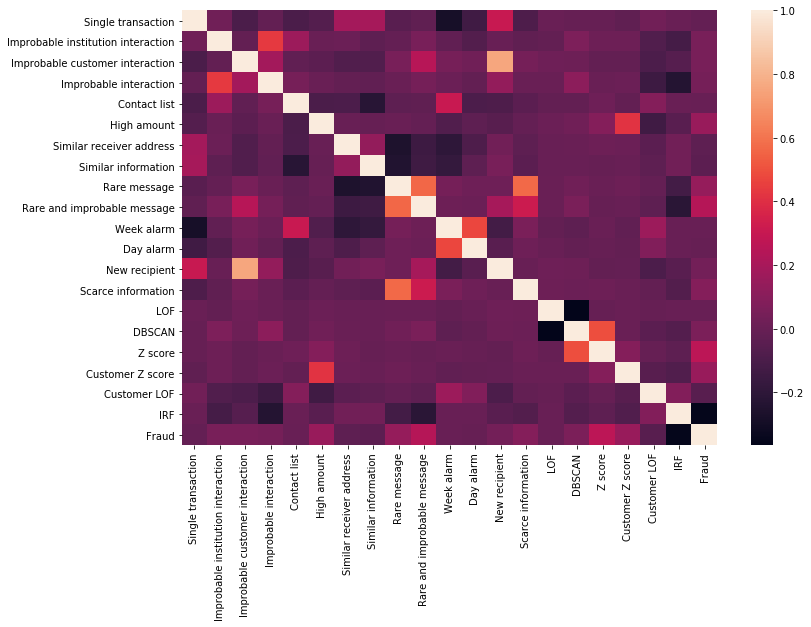

In [ ]:
corr = interesting.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, \
    xticklabels=corr.columns, \
    yticklabels=corr.columns)

### Log percentage of suspected fraud cases and copy the dataframe into an aptly named and easily readable one

In [ ]:
100*len(train[train["Fraud"]])/len(train)

Out[163]: 0.29629548190618593

In [ ]:
mt103_train = train.copy()

## Train Random Forest
### This is a proxy model to explain what the unsupervised ones considered most important

In [ ]:
try:
    mt103_train = mt103_train.drop(["Size", "Revision"], axis=1)
except:
    pass

# Transform datasets into dask dataframe. This would be unnecessary in well sized clusters, but I can't assure that in the future
# the clusters won't be changed and the whole pandas dataframe of all the messages will fit in memory. It is most important
# to think about this while training a model that constantly uses memory.
train = dd.from_pandas(mt103_train, npartitions=1 + int(len(mt103_train)/10000))
train["Message type"] = 103
appnd = dd.from_pandas(mt202_train, npartitions=1 + int(len(mt202_train)/10000))
appnd["Message type"] = 202
train = train.append(appnd)

# Format and explicitly fill values within columns. Filter out categorical features of customer specific data, so the variables
# used to explain why some cases are suspected frauds are easily explainable and generalizable themselves.
convett = ["ISO week", 'Weekday', 'Day', 'Month', 'Year']
train[convett] = train[convett].fillna(0).astype("int8")
drops = ["index", "semilla"]
ls = train.columns.values.tolist()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "int8"]
train["Fraud"] = train.loc[:, "Fraud"].apply(lambda x: 1 if x else 0, meta=pd.Series(dtype='int', name='Fraud')).astype(np.int8)
model_results = ["LOF", "Customer LOF", "Customer Z score", "Z score", "DBSCAN", "IRF", "semilla", "Fecha dato"]
trainable = train.drop(model_results, axis=1)
num_vars = [x for x in trainable.select_dtypes(include=numerics).columns.values.tolist() if x != "index" and x != "semilla" and x != "Fecha dato" and x != "Fraud"]
cat_vars = ['Currency code', 'Sender']
train[cat_vars] = train.loc[:,cat_vars].fillna("")
train[num_vars] = train.loc[:,num_vars].fillna(0)
trainable[cat_vars] = trainable.loc[:,cat_vars].fillna("")
trainable[num_vars] = trainable.loc[:,num_vars].fillna(0)
trainable = trainable.compute()
trainable = trainable[num_vars + cat_vars + ["Fraud"]]
trainable[num_vars] = trainable[num_vars].astype("float")
trainable[cat_vars] = trainable[cat_vars].astype("str")

# Create random forest preprocessing and training pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('categorical', OneHotEncoder())]
)
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, num_vars),
    ('categorical', cat_pipeline, cat_vars),
])

try:
    cat_vars.remove("Fraud")
except:
    pass

X = trainable.drop("Fraud", axis=1)
y = trainable.loc[:, "Fraud"]
pipeline_RF = Pipeline(steps=[('preprocessor', preprocessor),
                    ('anomaly detection RF', RandomForestRegressor(n_estimators=2500, oob_score=True))])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)
print(num_vars + cat_vars)

from joblib import parallel_backend
from os import cpu_count

# Apply the pipeline and log accuracy. Recall or F1 score are not KPIs in this case. Still, I could write them here since it's a binary
# classification problem.
# I could do hyperparameter tuning every time, but I just did it once and put the appropiate parameters here.
with parallel_backend('threading', n_jobs=cpu_count()):
    candidate_RF = pipeline_RF.fit(X_train, y_train)
    predictions = pipeline_RF.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictions.astype(np.int8)))
# Fail the job if the accurac
assert metrics.accuracy_score(y_test, predictions.astype(np.int8)) >= 0.99 

['Amount', 'ISO week', 'Weekday', 'Day', 'Month', 'Year', 'Contact list', 'Improbable institution interaction', 'Improbable customer interaction', 'Improbable interaction', 'Single transaction', 'Similar information', 'Similar receiver address', 'Week alarm', 'Day alarm', 'New recipient', 'Scarce information', 'High amount', 'Rare message', 'Rare and improbable message', 'Message type', 'Revision', 'Currency code', 'Sender']
Accuracy: 0.9991251843974064

### Calculate feature importances 

In [ ]:
importances = candidate_RF['anomaly detection RF'].feature_importances_
enc_cat_features = candidate_RF['preprocessor'].named_transformers_['categorical']['categorical'].get_feature_names_out()
feature_names = np.concatenate([num_vars, enc_cat_features]).tolist()
# feature_names = trainable.drop("Fraud", axis=1).columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances[(forest_importances >= forest_importances.to_numpy().mean()*0.5)]
forest_importances = forest_importances.sort_values(ascending=False)

# Explainability

### Graph of feature importances, just the ones that are not one-hot encoded and remain relevant

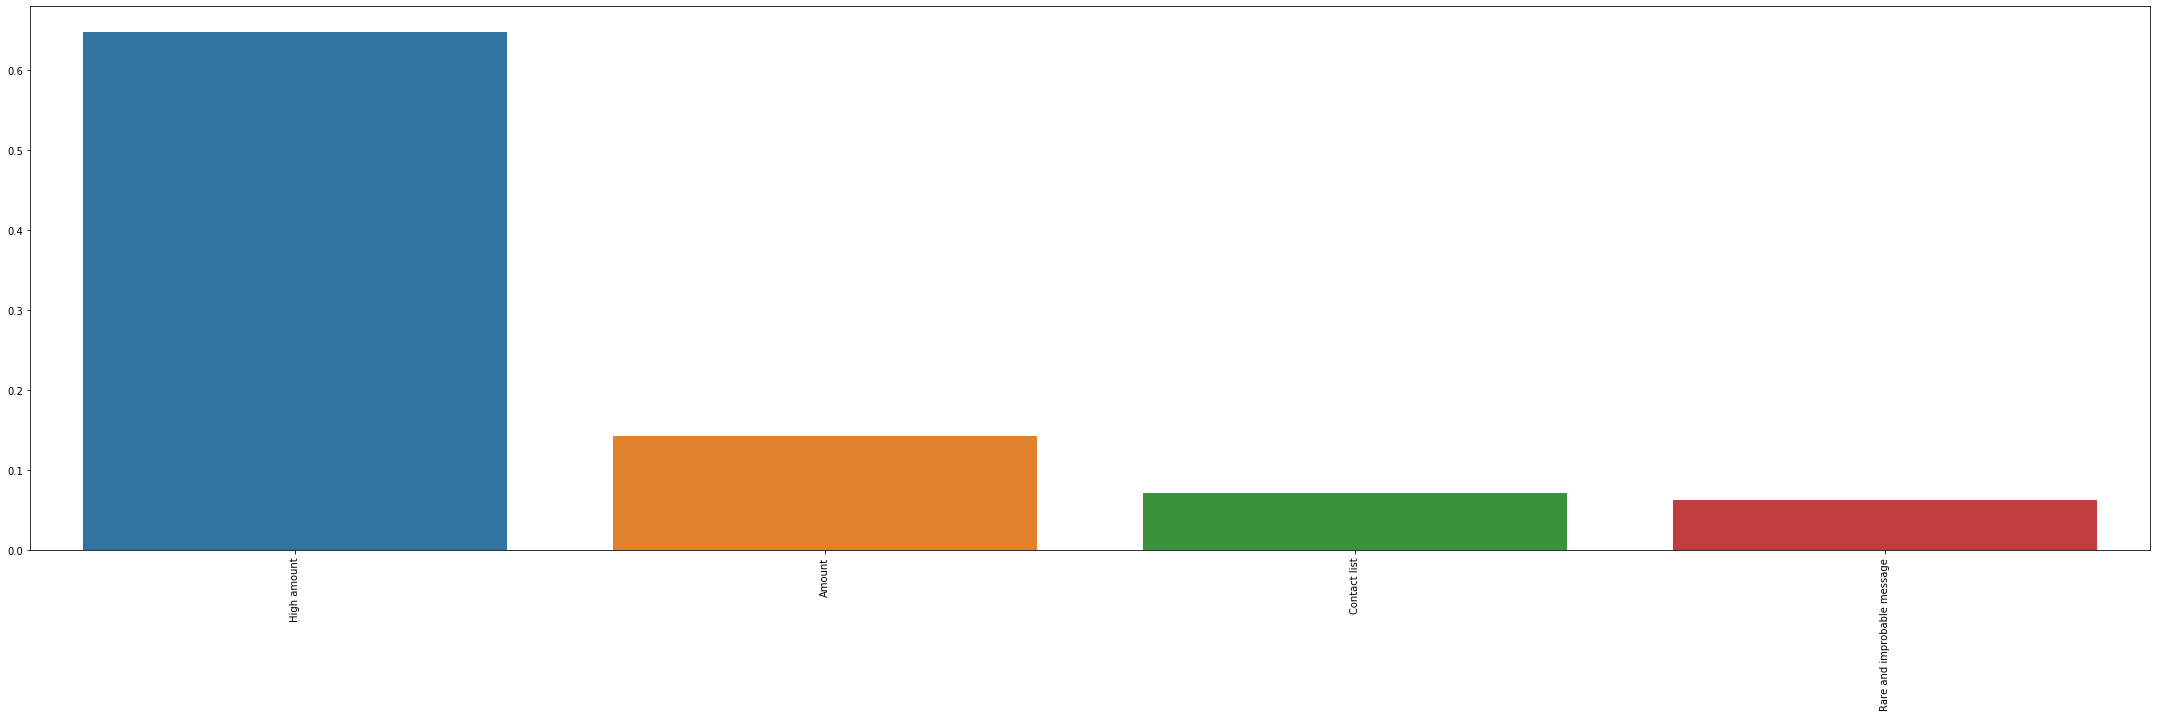

In [ ]:
plt.figure(figsize=(38,10))
xaxis = [var for var in forest_importances.index if var in num_vars or var in cat_vars and "High" not in var]
yaxis = [x[0] for x in forest_importances.loc[xaxis].reset_index().drop("index", axis=1).values]
g = sns.barplot(x= pd.Series(xaxis), y=yaxis)
g.set_xticklabels(
    labels= xaxis, rotation=90)
# forest_importances.plot()
plt.show()

In [ ]:
global_description = 'Importancias de características predefinidas en el fraude detectado globalmente: '
for i in range(len(xaxis)):
  global_description += "\n {}: {} %".format(xaxis[i], round(100*yaxis[i], 2))
global_description += "\n\n * Las otras características más importantes son circunstanciales y representan valores específicos de alguna columna"
train["Explanation"] = global_description

# Teradata

### Write alerts so the next job can read them from Teradata. The query is dynamically generated, I prefer to write the logic to write it instead of hardcoding it (that way I won't get any names wrong)

In [ ]:
def prepare_teradata(train: dd.DataFrame, num_vars: list):
    '''
    Filter suspicious messages from yesterday, write the alert for each row and generate a query to create today's alerts table.
    '''
    from datetime import date
    from datetime import timedelta
    today = date.today()
    if today.weekday() == 0:
        yesterday = today - timedelta(days = 3)
    else:
        yesterday = today - timedelta(days = 1)
    f1 = "%Y-%m-%d %H:%M:%S"
    f2 = "%Y-%m-%d"
    results = ["Customer LOF", "LOF", "DBSCAN", "IRF", "Z score", "Customer Z score", "Fraud"]
    for r in results:
        if r not in num_vars:
            num_vars.append(r)
    try:
        train = train.compute()
    except:
        pass
    train.loc[:,"Extraer"] = train["Fecha dato"].apply(lambda x: 1 if (x == yesterday) else 0)
    to_write = train[(train["Extraer"] == 1) & (train["Fraud"] == 1)]
    # print(to_write, train["Extraer"].std())
    if len(to_write) == 0:
        return None, None, None
    else:
        to_write = to_write.drop(["Extraer", "Date"], axis=1)
        to_write.loc[:,"Revision"] = 0
        to_write.loc[:,"Amount"] = to_write["Amount"].astype(np.float64)
        today = date.today()
        to_write.loc[:,"Process date"] = today
        to_write.replace([np.inf, -np.inf, np.nan], 0,inplace=True)
        selection = [v for v in num_vars if v != "Amount"]
        to_write[selection] = to_write[selection].astype(np.int8)
        to_write[[v for v in to_write.columns.values.tolist() if v not in num_vars]] = to_write[[v for v in to_write.columns.values.tolist() if v not in num_vars]].astype(str)
        write_dummy = to_write.copy()
        to_write["Individual_explanation"] = np.array(["Sospecha de fraude por " + to_write["Currency code"] + " " + str(to_write["Amount"]) + ". La cuenta del cliente es " + to_write["Account with institution"].strip("/") + " " + to_write["Ordering customer account"].strip("/") + " y su dirección es " + to_write['Ordering customer address'] + ".\nLos criterios activados para sospechar fraude son:\n Criterio 1 (Outlier local o global): " + \
        str( (to_write["DBSCAN"] < 0) & ((to_write["IRF"] < 0) | ((to_write["Customer LOF"] < 0) & (to_write["LOF"] < 0)) ) ) + \
        "\n Criterio 2 (Outlier global): " + str((to_write["IRF"] < 0) & ((to_write["Rare message"] == 1) | (to_write["Improbable interaction"] == 1) | (to_write["Improbable customer interaction"] == 1) )) + \
        "\n Criterio 3 (Monto demasiado alto): " + str((to_write["Z score"] == 1) & (to_write["Customer Z score"] == 1)) + \
        "\n Criterio 4 (Características demasiado extrañas de encontrar juntas): " + str(to_write["Rare and improbable message"] == 1) + \
        "\nEl destinatario de la transacción tiene la cuenta " + to_write["Beneficiary customer account"] + " en la institución " + to_write["Receiver"] + " y su dirección es " + to_write["Beneficiary customer address"] + \
         "\n---------------------------------------------------------------------------------------------------------------------------\n" + to_write["Explanation"] for i, to_write in write_dummy.iterrows()])
        to_write = to_write.drop("Explanation", axis=1)
        try:
            to_write = to_write.drop('Currencyinstructed amount', axis=1)
        except:
            pass
        maxlen = max(to_write["Individual_explanation"].apply(lambda x: len(x)))
        query = " ("
        lss = "("
        for col in to_write.columns.values.tolist():
            formatted_name = "s_" + "_".join([w.lower() for w in col.split(" ")])
            if col not in num_vars:
                if col != "Individual_explanation":
                    if "date" not in col.lower() and "date" not in formatted_name and "fecha" not in col.lower():
                        query += '{} VARCHAR(200), '.format(formatted_name)
                    else:
                        query += '{} DATE, '.format(formatted_name)
                else:
                    query += '{} VARCHAR({}), '.format( formatted_name, str(1 + maxlen) )
            else:
                if "s_amount" == formatted_name:
                    query += '{} FLOAT, '.format(formatted_name)
                else:
                    if "date" not in col.lower() and "date" not in formatted_name and "fecha" not in col.lower():
                        query += '{} SMALLINT, '.format(formatted_name)
                    else:
                        query += '{} DATE, '.format(formatted_name)
            lss += "?,"
        query = query[:len(query)-2] + ")"
        lss = lss[:len(lss)-1] + ")"
        return query, lss, to_write

In [ ]:
import teradatasql

with teradatasql.connect (host=HOST,user=user_teradata,password=pwd_teradata) as con:
    with con.cursor () as cur:
        sTableName = "BCISF.SWIFT_ALERTS"
        try:
            sRequest = "DROP TABLE " + sTableName
            print (sRequest)
            cur.execute (sRequest)
        except Exception as ex:
            print ("Ignoring", str (ex).split ("\n") [0])
        
        query, lss, to_write = prepare_teradata(train, num_vars)
            
        if to_write is not None:
            sRequest = "CREATE TABLE " + sTableName + query
            print ('CREANDO TABLA '+sTableName)
            cur.execute (sRequest)
            print(query)
            print("\n")
            print(to_write)
            try:
                for m in to_write["Individual_explanation"]:
                    print(m)
                    print("\n")
            except:
                print("No se pudieron imprimir las alertas")

            sRequest = "{fn teradata_nativesql}{fn teradata_autocommit_off}"
            print (sRequest)
            cur.execute (sRequest)

            data = list(to_write.itertuples(index=False, name=None))
            
            try:
                sInsert = "{fn teradata_try_fastload}INSERT INTO " + sTableName + lss
                print (sInsert)
                cur.execute (sInsert, data)
            except:
                sInsert = "INSERT INTO " + sTableName + lss
                print (sInsert)
                cur.execute (sInsert, data)

            sRequest = "{fn teradata_nativesql}{fn teradata_get_warnings}" + sInsert
            print (sRequest)
            cur.execute (sRequest)
            [ print (row) for row in cur.fetchall () ]

            sRequest = "{fn teradata_nativesql}{fn teradata_get_errors}" + sInsert
            print (sRequest)
            cur.execute (sRequest)
            [ print (row) for row in cur.fetchall () ]

            sRequest = "{fn teradata_nativesql}{fn teradata_logon_sequence_number}" + sInsert
            print (sRequest)
            cur.execute (sRequest)
            [ print (row) for row in cur.fetchall () ]

            sRequest = "{fn teradata_nativesql}{fn teradata_autocommit_on}"
            print (sRequest)
            cur.execute (sRequest)

            sRequest = "SELECT count(*) FROM " + sTableName
            print (sRequest)
            cur.execute (sRequest)
            [ print (row) for row in cur.fetchall () ]

            print('Terminó la carga')
        else:
            dbutils.notebook.exit("No se encontraron alertas por las transacciones de ayer.")

DROP TABLE BCISF.SWIFT_ALERTS
CREANDO TABLA BCISF.SWIFT_ALERTS
 (s_semilla VARCHAR(200), s_fecha_dato DATE, s_sender VARCHAR(200), s_receiver VARCHAR(200), s_validation_flag VARCHAR(200), s_unique_endtoend_transaction_reference VARCHAR(200), s_time_indication VARCHAR(200), s_senders_reference VARCHAR(200), s_transaction_reference_number VARCHAR(200), s_related_reference VARCHAR(200), s_bank_operation_code VARCHAR(200), s_ordering_institution VARCHAR(200), s_reimbursement VARCHAR(200), s_senders_correspondent VARCHAR(200), s_intermediary VARCHAR(200), s_account_with_institution VARCHAR(200), s_receivers_correspondent VARCHAR(200), s_beneficiary_institution VARCHAR(200), s_third_reimbursement_institution VARCHAR(200), s_remittance_information VARCHAR(200), s_details_of_charges VARCHAR(200), s_charges VARCHAR(200), s_senders_charges VARCHAR(200), s_receivers_charges VARCHAR(200), s_sender_to_receiver_information VARCHAR(200), s_exchange_rate VARCHAR(200), s_currency_code VARCHAR(200), s_amount FLOAT, s_iso_week SMALLINT, s_ordering_customer_account VARCHAR(200), s_beneficiary_customer_account VARCHAR(200), s_ordering_customer_address VARCHAR(200), s_beneficiary_customer_address VARCHAR(200), s_weekday SMALLINT, s_day SMALLINT, s_month SMALLINT, s_year SMALLINT, s_contact_list SMALLINT, s_improbable_institution_interaction SMALLINT, s_improbable_customer_interaction SMALLINT, s_improbable_interaction SMALLINT, s_single_transaction SMALLINT, s_similar_information SMALLINT, s_similar_receiver_address SMALLINT, s_language VARCHAR(200), s_week_alarm SMALLINT, s_day_alarm SMALLINT, s_new_recipient SMALLINT, s_scarce_information SMALLINT, s_high_amount SMALLINT, s_customer_lof SMALLINT, s_customer_z_score SMALLINT, s_rare_message SMALLINT, s_rare_and_improbable_message SMALLINT, s_lof SMALLINT, s_dbscan SMALLINT, s_z_score SMALLINT, s_irf SMALLINT, s_fraud SMALLINT, s_message_type SMALLINT, s_ordering_customer VARCHAR(200), s_beneficiary_customer VARCHAR(200), s_revision SMALLINT, s_process_date DATE, s_individual_explanation VARCHAR(1079))


 semilla ... Individual_explanation
2708 257204 ... Sospecha de fraude por USD 4000000.0. La cuent...
19054 256711 ... Sospecha de fraude por USD 78000000.0. La cuen...
102835 256529 ... Sospecha de fraude por CNY 358419.0. La cuenta...
132735 258205 ... Sospecha de fraude por USD 100000.0. La cuenta...
179785 256983 ... Sospecha de fraude por USD 55000000.0. La cuen...

[5 rows x 65 columns]
{fn teradata_nativesql}{fn teradata_autocommit_off}
{fn teradata_try_fastload}INSERT INTO BCISF.SWIFT_ALERTS(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
{fn teradata_nativesql}{fn teradata_get_warnings}{fn teradata_try_fastload}INSERT INTO BCISF.SWIFT_ALERTS(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
['']
{fn teradata_nativesql}{fn teradata_get_errors}{fn teradata_try_fastload}INSERT INTO BCISF.SWIFT_ALERTS(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
['']
{fn teradata_nativesql}{fn teradata_logon_sequence_number}{fn teradata_try_fastload}INSERT INTO BCISF.SWIFT_ALERTS(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
['10302029']
{fn teradata_nativesql}{fn teradata_autocommit_on}
SELECT count(*) FROM BCISF.SWIFT_ALERTS
[5]
Terminó la carga